In [3]:
import os
import json
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn import metrics
from sklearn.model_selection import cross_val_score, GridSearchCV

from sklearn.covariance import EmpiricalCovariance, EllipticEnvelope, MinCovDet
from sklearn.neighbors import KNeighborsClassifier, LocalOutlierFactor
from sklearn.cluster import DBSCAN, KMeans
from sklearn.svm import OneClassSVM

from scipy.cluster.hierarchy import dendrogram, fcluster, cophenet, set_link_color_palette
from scipy.spatial.distance import squareform, mahalanobis
from fastcluster import linkage, pdist

# saving models
from sklearn.externals import joblib

# incase we want to try some cleaning steps to see if it improves the model
import Clean_Function_Helpers as cfh

In [2]:
plt.rcParams['figure.figsize'] = (9,6)
sns.set_style('darkgrid')

SEED = 1111

## Overview

Taking two different approaches. 

    1. Try to model the difference between real and fraudulent charges.
        - Classifiers like Logistic Regression, NaiveBayes, Tree Ensembles etc
        - Sampling approaches over vs undersampling
    2. Try to identify core boundary of real charges and identify anything outside this boundary as fraudulent.
        - Covariance estimates, Local Outlier Factor, Clustering, One Class SVM, Hierarchical Clustering, 
        Model-based bayesian clustering.
        
This notebook focuses on the second approach: using robust statistical methods as well as un-supervised learning to identify outliers.

### Read Data

In [5]:
df = pd.read_csv('creditcard.csv')
df.Class.value_counts()/df.Class.value_counts().sum()

0    0.998273
1    0.001727
Name: Class, dtype: float64

In [66]:
# We will test different transforms of the data

sub_cols = df.columns.drop(['Time', 'Class'])

scaled_df = cfh.scale_data(df, MinMaxScaler(), sub_cols)
deskewed = cfh.deskew_df(scaled_df, topn=10)

In [74]:
x = df[sub_cols]
y = df.Class


### Minimum Covariance Determinant

Sklearn spits continually spits out RuntimeWarnings on the regular dataset leading me to believe that the data is not well approximated by a normal distribution. Running the Elliptic Envelope on scaled-deskewed data seems to solve the issue.

In [79]:
x = deskewed[sub_cols]

params = {
    'contamination': [0.001,0.005, 0.01],
    'support_fraction': [0.6, 0.7, 0.8, 0.9]
}

def scorer(y, ypred):
    "Calculate F1 Score for Elliptic Envelope labels"
    ypred = np.where(ypred>0, 0, 1)
    return metrics.f1_score(y,ypred)
scorer = metrics.make_scorer(scorer)

# THIS TAKES 2 HOURS TO RUN
ee = EllipticEnvelope(assume_centered=True,random_state=SEED)
grid = GridSearchCV(ee, params, scorer, cv=4)
grid.fit(x,y)

/Users/rick.shapiro/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/rick.shapiro/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/rick.shapiro/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional i

/Users/rick.shapiro/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/rick.shapiro/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/rick.shapiro/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional i

/Users/rick.shapiro/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/rick.shapiro/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/rick.shapiro/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional i

GridSearchCV(cv=4, error_score='raise',
       estimator=EllipticEnvelope(assume_centered=True, contamination=0.1, random_state=1111,
         store_precision=True, support_fraction=None),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'contamination': [0.001, 0.005, 0.01], 'support_fraction': [0.6, 0.7, 0.8, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(scorer), verbose=0)

In [80]:
print(grid.best_score_)
print(grid.best_params_)


0.42045984408933085
{'contamination': 0.001, 'support_fraction': 0.7}


In [81]:
grid.best_estimator_

EllipticEnvelope(assume_centered=True, contamination=0.001, random_state=1111,
         store_precision=True, support_fraction=0.7)

In [82]:
ee = EllipticEnvelope(assume_centered=True, contamination=0.001, support_fraction=0.7,random_state=SEED)
ee.fit(x,y)
ypred = np.where(ee.predict(x)>0, 0, 1)
print(metrics.f1_score(y,ypred))
print(metrics.recall_score(y,ypred))
print(metrics.precision_score(y,ypred))

/Users/rick.shapiro/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


0.5456885456885457
0.43089430894308944
0.743859649122807


We can use predictions as features, or maybe even better would be to just feed in Mahalanobis distances from best mcd.

### Local Outlier Factor

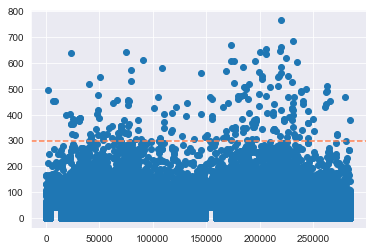

In [43]:
robust_mean = mcd.location_
robust_cov = mcd.covariance_
dists = mcd.dist_

mask = np.ones_like(dists).astype(bool)
mask[np.argmax(dists)] = 0

plt.scatter(range(len(dists[mask])), np.power(dists[mask], 0.3333)) 
plt.axhline(300, color = 'coral', linestyle='--')
plt.ylabel('Cubic Root of Mahalanobis Distances')


In [45]:
def get_score(mdists, ytrue, n=1000):
    "Finds thresholds for mahalanobis distances that maximize precision/recall/f1"
    best_precision = {'thresh':0, 'precision':0, 'recall':0, 'f1':0}
    best_recall = {'thresh':0, 'precision':0, 'recall':0, 'f1':0}
    best_f1 = {'thresh':0, 'precision':0, 'recall':0, 'f1':0}

    for thresh in np.linspace(mdists.median(), mdists.max(), n):
        ypred = np.where(mdists>=thresh, 1, 0)
        precision = metrics.precision_score(ytrue, ypred)
        recall = metrics.recall_score(ytrue, ypred)
        f1 = metrics.f1_score(ytrue, ypred)
        if precision > best_precision['precision']:
            best_precision = {'thresh':thresh, 'precision':precision, 'recall':recall, 'f1':f1}
            print("New Best Precision")
            print(best_precision)
        if recall > best_recall['recall']:
            best_recall = {'thresh':thresh, 'precision':precision, 'recall':recall, 'f1':f1}
            print("New Best Recall")
            print(best_recall)
        if f1 > best_f1['f1']:
            best_f1 = {'thresh':thresh, 'precision':precision, 'recall':recall, 'f1':f1}
            print("New Best F1")
            print(best_f1)
    
    return best_precision, best_recall, best_f1
        
        
        
        

In [46]:
get_score(dists,y)

/Users/rick.shapiro/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/rick.shapiro/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


({'f1': 0.022292993630573247,
  'precision': 0.013861386138613862,
  'recall': 0.056910569105691054,
  'thresh': 2191254.7340931483},
 {'f1': 0.00344902522975976,
  'precision': 0.001727491696101908,
  'recall': 1.0,
  'thresh': 3.8299886670314516},
 {'f1': 0.022292993630573247,
  'precision': 0.013861386138613862,
  'recall': 0.056910569105691054,
  'thresh': 2191254.7340931483})